In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms.functional as ft
from torch.utils.data import Dataset
!pip install -U albumentations
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import torch.optim as optim
from torch.utils.data import DataLoader

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.3/200.3 kB 5.4 MB/s eta 0:00:00ta 0:00:01
  Attempting uninstall: albucore
    Found existing installation: albucore 0.0.13
    Uninstalling albucore-0.0.13:
      Successfully uninstalled albucore-0.0.13
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.4.14
    Uninstalling albumentations-1.4.14:
      Successfully uninstalled albumentations-1.4.14


In [2]:
!nvidia-smi

Fri Sep 20 04:48:31 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.90.07              Driver Version: 550.90.07      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   37C    P8              9W /   70W |       1MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# Creating Model

In [3]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)


class UNET(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, features= [64, 128, 256, 512]):
        super(UNET, self).__init__()

        self.downs = nn.ModuleList()
        self.ups = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down-sampling
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up-sampling
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottom = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottom(x)

        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx // 2]

            if x.shape != skip_connection.shape:  # Required if we have not chosen the input and output size
                # according to MaxPool2d
                x = ft.resize(x, size=(skip_connection.shape[2:]))
            concat_skip = torch.concat((skip_connection, x), dim=1)

            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)

# Creating Dataset

In [33]:
class WaterEdgeDataset(Dataset):
    def __init__(self, image_dir, mask_dir, images, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transforms = transform
        self.images = images
        self.masks = os.listdir(self.mask_dir)


    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img_path = os.path.join(self.image_dir, self.images[index].replace("\n", ""))
        mask_path = os.path.join(self.mask_dir, self.images[index].replace("\n", "").replace("image", "mask"))

        image = np.array(Image.open(img_path).convert("RGB"))
        mask = np.array(Image.open(mask_path).convert("L"), dtype=np.float32) / 255

        if self.transforms:
            augmentations = self.transforms(image=image, mask=mask)
            image = augmentations["image"]
            mask = augmentations["mask"]

        return image, mask

In [34]:
train_images_pth = "/kaggle/input/image-splits/image_split/Train images.txt"
val_images_pth = "/kaggle/input/image-splits/image_split/val images.txt"
test_images_pth = "/kaggle/input/image-splits/image_split/Water Land Segment Images.txt"

In [35]:
with open(train_images_pth, 'r') as file:
    train_images = file.readlines()

file.close()

with open(val_images_pth, 'r') as file:
    val_images = file.readlines()

file.close()

with open(test_images_pth, 'r') as file:
    test_images = file.readlines()

file.close()

len(train_images), len(val_images), len(test_images)

(5722, 1226, 1227)

In [25]:
train_images

['image_7918.jpg\n',
 'image_1350.jpg\n',
 'image_7340.jpg\n',
 'image_5748.jpg\n',
 'image_7872.jpg\n',
 'image_2200.jpg\n',
 'image_4010.jpg\n',
 'image_1163.jpg\n',
 'image_169.jpg\n',
 'image_2478.jpg\n',
 'image_3711.jpg\n',
 'image_2596.jpg\n',
 'image_5945.jpg\n',
 'image_6061.jpg\n',
 'image_898.jpg\n',
 'image_1853.jpg\n',
 'image_933.jpg\n',
 'image_7728.jpg\n',
 'image_7978.jpg\n',
 'image_5754.jpg\n',
 'image_3374.jpg\n',
 'image_2332.jpg\n',
 'image_2746.jpg\n',
 'image_7437.jpg\n',
 'image_2107.jpg\n',
 'image_5829.jpg\n',
 'image_1845.jpg\n',
 'image_6146.jpg\n',
 'image_643.jpg\n',
 'image_7606.jpg\n',
 'image_6843.jpg\n',
 'image_6072.jpg\n',
 'image_6294.jpg\n',
 'image_6973.jpg\n',
 'image_4992.jpg\n',
 'image_3628.jpg\n',
 'image_8138.jpg\n',
 'image_1731.jpg\n',
 'image_467.jpg\n',
 'image_1813.jpg\n',
 'image_3884.jpg\n',
 'image_2878.jpg\n',
 'image_1075.jpg\n',
 'image_2521.jpg\n',
 'image_870.jpg\n',
 'image_7183.jpg\n',
 'image_6130.jpg\n',
 'image_3238.jpg\n'

In [41]:
LEARNING_RATE = 1e-6
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 8
NUM_EPOCHS = 5
NUM_WORKERS = 4
IMAGE_HEIGHT = 640
IMAGE_WIDTH = 640
PIN_MEMORY = True
LOAD_MODEL = True
IMAGE_DIR = "/kaggle/input/water-land-edge-segmentation-mods/seg_data_jpg/images"
MASK_DIR = "/kaggle/input/water-land-edge-segmentation-mods/seg_data_jpg/masks"

In [27]:
def train_fn(loader, model, optimizer, loss_fn, scaler):
    loop = tqdm(loader)

    for batch_idx, (data, targets) in enumerate(loop):
        data = data.to(device=DEVICE)
        targets = targets.float().unsqueeze(1).to(device=DEVICE)

        # Forward
        with torch.amp.autocast('cuda'):
            predictions = model(data)
            loss = loss_fn(predictions, targets)

        # Backward
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # Updating tqdm loop
        loop.set_postfix(loss=loss.item())

In [28]:
train_transforms = A.Compose(
    [
        A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
        A.Rotate(limit=35, p=1.0),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.1),
        A.Normalize(
            mean=[0.0, 0.0, 0.0],
            std=[1.0, 1.0, 1.0],
            max_pixel_value=255.0,
        ),
        ToTensorV2()
    ],
)

val_transforms = A.Compose(
    [
        A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
        A.Normalize(
            mean=[0.0, 0.0, 0.0],
            std=[1.0, 1.0, 1.0],
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
    ]
)

In [29]:
def save_checkpoint(state, filename="my_checkpoint.pth.tar"):
    print("=> Saving Checkpoint")
    torch.save(state, filename)


def load_checkpoint(checkpoint, model: torch.nn.Module):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])
    
def check_accuracy(loader, model, device):
    num_correct = 0
    num_pixels = 0
    dice_score = 0
    model.eval()

    with torch.inference_mode():
        for x, y in loader:
            x, y = x.to(device), y.to(device).unsqueeze(1)
            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()
            num_correct += (preds == y).sum()
            num_pixels += torch.numel(preds)
            dice_score += (2*(preds * y).sum()) / ((preds + y).sum() + 1e-8)

    print(
        f"Got {num_correct}/{num_pixels} with acc {num_correct/num_pixels*100:.4f}"
    )

    print(f"Dice score: {dice_score/len(loader)}")

    model.train()

In [30]:
def get_loaders(
    img_dir,
    mask_dir,
    train_images,
    val_images,
    batch_size,
    train_transform,
    val_transform,
    num_workers,
    pin_memory=True
):
    train_ds = WaterEdgeDataset(image_dir=img_dir,
                                mask_dir=mask_dir,
                                images=train_images,
                                transform=train_transform)

    train_loader = DataLoader(
        train_ds,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=pin_memory,
        shuffle=True
    )

    val_ds = WaterEdgeDataset(image_dir=img_dir,
                              mask_dir=mask_dir,
                              images=val_images,
                              transform=val_transform)

    val_loader = DataLoader(
        val_ds,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=pin_memory,
        shuffle=False
    )
    
    return train_loader, val_loader

In [42]:
model = UNET(in_channels=3, out_channels=1)
model = nn.DataParallel(model)
model.to(device=DEVICE)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
train_loader, val_loader = get_loaders(
    IMAGE_DIR,
    MASK_DIR,
    train_images,
    val_images,
    BATCH_SIZE,
    train_transforms,
    val_transforms,
    num_workers=NUM_WORKERS
)

if LOAD_MODEL:
    load_checkpoint(torch.load("/kaggle/working/my_checkpoint.pth.tar"), model)
scaler = torch.amp.GradScaler('cuda')

/tmp/ipykernel_36/2371130163.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  load_checkpoint(torch.load("/kaggle/working/my_checkpoint.pth.tar"), model)


=> Loading checkpoint


In [43]:
check_accuracy(val_loader, model, device=DEVICE)
for epoch in range(NUM_EPOCHS):
    train_fn(train_loader, model, optimizer, loss_fn, scaler)
    if epoch == 4:
        checkpoint = {
            "state_dict": model.state_dict(),
            "optimizer": optimizer.state_dict()
        }
        save_checkpoint(checkpoint)
    check_accuracy(val_loader, model, device=DEVICE)

Got 499680775/502169600 with acc 99.5044
Dice score: 0.6831550598144531


100%|██████████| 716/716 [07:27<00:00,  1.60it/s, loss=0.00901]


Got 499679419/502169600 with acc 99.5041
Dice score: 0.6801381707191467


100%|██████████| 716/716 [07:27<00:00,  1.60it/s, loss=0.00835]


Got 499677358/502169600 with acc 99.5037
Dice score: 0.6834245324134827


100%|██████████| 716/716 [07:27<00:00,  1.60it/s, loss=0.0126] 


Got 499680999/502169600 with acc 99.5044
Dice score: 0.6847284436225891


100%|██████████| 716/716 [07:29<00:00,  1.59it/s, loss=0.00604]


Got 499681414/502169600 with acc 99.5045
Dice score: 0.6853955984115601


100%|██████████| 716/716 [07:29<00:00,  1.59it/s, loss=0.00522]


=> Saving Checkpoint
Got 499679912/502169600 with acc 99.5042
Dice score: 0.6825950145721436


In [45]:
!pip install -q torchinfo
from torchinfo import summary

summary(model=model,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                       Input Shape          Output Shape         Param #              Trainable
DataParallel (DataParallel)                   [1, 3, 224, 224]     [1, 1, 224, 224]     --                   True
├─UNET (module)                               [1, 3, 224, 224]     [1, 1, 224, 224]     31,037,633           True
├─UNET (module)                               --                   --                   --                   True
│    └─ModuleList (downs)                     --                   --                   (recursive)          True
│    │    └─DoubleConv (0)                    [1, 3, 224, 224]     [1, 64, 224, 224]    38,848               True
│    │    └─DoubleConv (0)                    --                   --                   38,848               True
│    └─MaxPool2d (pool)                       [1, 64, 224, 224]    [1, 64, 112, 112]    --                   --
│    └─ModuleList (downs)                     --                   --                

# Testing on Test Dataset

In [49]:
import random
import matplotlib.pyplot as plt
import cv2

In [128]:
rand_image_pth = random.choice(test_images).replace('\n', '')
rand_image_pth
img_pth = os.path.join(IMAGE_DIR, rand_image_pth)

mask_pth = os.path.join(MASK_DIR, rand_image_pth.replace('image', 'mask'))
img_pth, mask_pth

img = np.array(Image.open(img_pth).convert("RGB"))
mask = np.array(Image.open(mask_pth).convert("L"), dtype=np.float32) / 255

test_transform = A.Compose([
    A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
    A.Normalize(
        mean=[0.0, 0.0, 0.0],
        std=[1.0, 1.0, 1.0],
        max_pixel_value=255.0,
    ),
    ToTensorV2(),
])

augmentations = test_transform(image=img, mask=mask)
img = augmentations["image"].to(DEVICE)
mask = augmentations["mask"].to(DEVICE)
img = img.unsqueeze(0)
model.eval()
with torch.inference_mode():
    preds = torch.sigmoid(model(img))
    preds = (preds > 0.5).float()
    
predicted_mask = preds.to("cpu").squeeze(0).permute(1, 2, 0).numpy() * 255
gt_mask = mask.to('cpu').unsqueeze(0).permute(1, 2, 0).numpy()
input_image = img.to('cpu').squeeze(0).permute(1, 2, 0).numpy()

plt.imsave("inputimg1.jpg", input_image)
# plt.imsave("premsk1.jpg", predicted_mask)
# plt.imsave("gtmsk1.jpg", gt_mask)
# cv2.imwrite("predmsk", predicted_mask * 255)
np.save("pred_msk1.npy", predicted_mask)
np.save("gt_msk1.npy", predicted_mask)

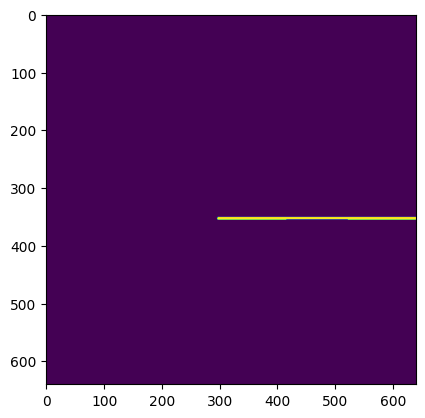

In [97]:
plt.imshow(gt_mask)

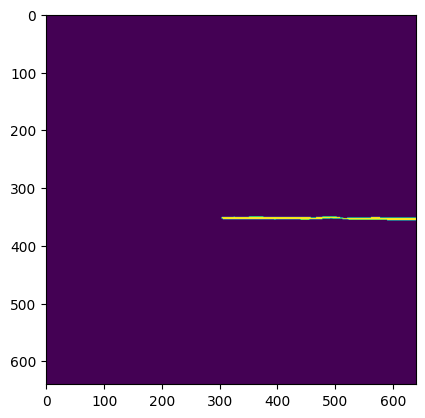

In [98]:
plt.imshow(predicted_mask)